# check oof df

In [1]:
import os
import gc
import yaml
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/kaggle/src/dss_utils")
sys.path.append("/kaggle/src/exp")
sys.path.append("/kaggle/src/model")
sys.path.append("/kaggle/src/data")
from dss_metrics import score
from training_loop import get_valid_values_dict, concat_valid_input_info, get_oof_df, get_key_df
from dss_model import get_model
from dss_dataloader import get_loader


In [2]:
output_dir = "/kaggle/working"
exp_name = "exp020_dense_chh_skffold_epoch30"
folds = [0, 1, 2, 3, 4]
# folds = [0]
oof_df = pd.DataFrame()
for i in folds:
    print("fold", i)
    df = pd.read_parquet(os.path.join(output_dir, "_oof", exp_name, f"fold{i}_best_oof_df.parquet"))
    oof_df = pd.concat([oof_df, df], axis=0)


print(len(oof_df["series_id"].unique()))   


fold 0
fold 1
fold 2
fold 3
fold 4
269


In [3]:
oof_df = oof_df.sort_values(["series_id", "step"])


In [17]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn


def postprocess_downsample_fn(df, N=3, maxpool_kernel_size=3, maxpool_stride=1):
    df = df.copy()
    df = df[df["second"]==0].reset_index(drop=True)
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    not_predicted_mask = (df["class_pred"] != -1).astype(int)
    df["event_pred"] = df["event_pred"] * not_predicted_mask

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df["onset_pred"] = np.clip(-df["event_pred"], 0, 1)
    df["wakeup_pred"] = np.clip(df["event_pred"], 0, 1)
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df


In [18]:
df = postprocess_downsample_fn(oof_df)


In [22]:
len(df)


6896820

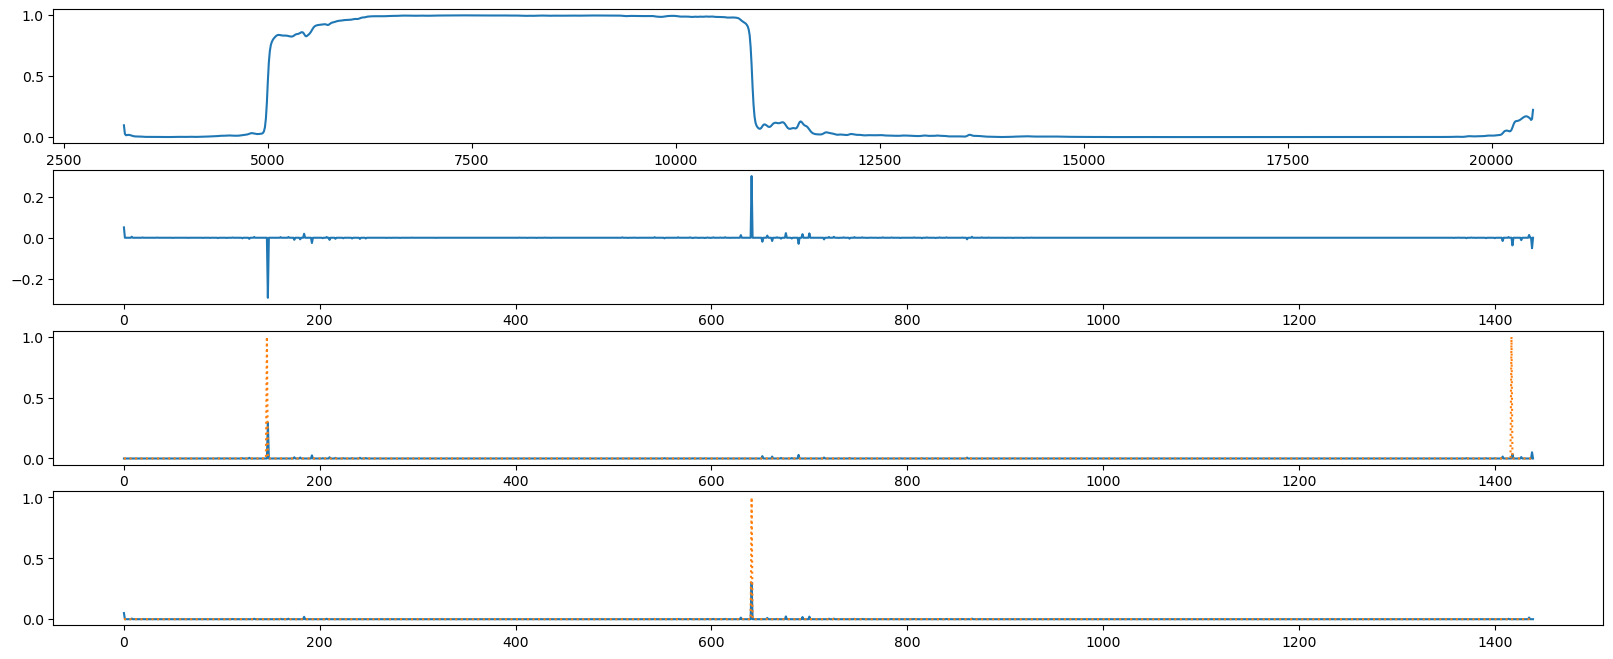

In [21]:
show_len = 1440
for series_id in df["series_id"].unique():
    check_df = df[df["series_id"]==series_id]
    if len(check_df) < show_len:
        continue
    check_df = check_df.iloc[:show_len]
    plt.figure(figsize=(20, 8))
    plt.subplot(4, 1, 1)
    plt.plot(check_df["step"], check_df["class_pred"], label="class_pred")
    plt.subplot(4, 1, 2)
    plt.plot(check_df["event_pred"], label="event_pred")
    plt.subplot(4, 1, 3)
    plt.plot(check_df["onset_pred"], label="onset_pred")
    plt.plot(check_df["event_onset"],":", label="event_onset")
    plt.subplot(4, 1, 4)
    plt.plot(check_df["wakeup_pred"], label="wakeup_pred")
    plt.plot(check_df["event_wakeup"], ":",label="event_wakeup")
    plt.show()
    break


,series_id,step,wakeup_pred,onset_pred,class_pred,event_pred
0,038441c925bb,3240.0,0.050517,0.000000,0.097072,0.050517
1,038441c925bb,3252.0,0.000000,-0.000000,0.026753,0.000000
2,038441c925bb,3264.0,0.000000,-0.000000,0.015840,0.000000
3,038441c925bb,3276.0,0.000000,-0.000000,0.016279,0.000000
4,038441c925bb,3288.0,-0.000000,0.000000,0.017894,-0.000000
...,...,...,...,...,...,...
6896815,fe90110788d2,589260.0,-0.000000,0.000000,0.002955,-0.000000
6896816,fe90110788d2,589272.0,-0.000000,0.000000,0.003491,-0.000000
6896817,fe90110788d2,589284.0,-0.000000,0.000000,0.005732,-0.000000
6896818,fe90110788d2,589296.0,-0.000000,0.000000,0.014910,-0.000000


In [29]:
over_all_oof_dir = os.path.join(output_dir, "_overall_oof", exp_name)
os.makedirs(over_all_oof_dir, exist_ok=True)
# df.to_parquet(os.path.join(over_all_oof_dir, "oof_df.parquet"))
df[["series_id", "step", "wakeup_pred", "onset_pred", "class_pred", "event_pred"]].to_parquet(os.path.join(over_all_oof_dir, "oof_df.parquet"))
